In [ ]:
import pandas as pd
import requests
import requests
from bs4 import BeautifulSoup
import re
import pandas as pd

cookies = {
}

headers = {
}

res = pd.DataFrame()
for rn in range(1, 26):
    data = ''.replace('{page_number}', str(rn)).encode()

    response = requests.post('https://api.cian.ru/ebc-analytics/event-enrichment/', cookies=cookies, headers=headers,
                             data=data)

    res = pd.concat([res, pd.DataFrame().from_records(response.json().get('products'))])


def parse_property_info(text):
    result = {}

    # Общая площадь
    total_match = re.search(r'Общая площадь\s*([\d,]+)\s*м²', text)
    if total_match:
        result['total_area'] = total_match.group(1)

    # Площадь кухни
    kitchen_match = re.search(r'Площадь кухни\s*([\d,]+)\s*м²', text)
    if kitchen_match:
        result['kitchen_area'] = kitchen_match.group(1)

    # Этаж
    floor_match = re.search(r'Этаж\s*(\d+)\s*из\s*(\d+)', text)
    if floor_match:
        result['floor'] = floor_match.group(1)
        result['total_floors'] = floor_match.group(2)

    # Год постройки
    year_match = re.search(r'Год постройки\s*(\d+)', text)
    if year_match:
        result['build_year'] = year_match.group(1)

    return result


out = []
for id in set(res.id):
    url = f'https://www.cian.ru/sale/flat/{id}/'
    headers = {
        "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8",
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3"
    }

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')

    adress = ', '.join([val.text.strip() for val in soup.find_all('a', {'data-name': 'AddressItem'})])
    stations = [val.text.strip() for val in soup.find_all('li', {'data-name': 'UndergroundItem'})]
    cleaned_stations = list(set([re.sub(r'\d+\s*мин\.?', '', station).strip() for station in stations]))
    text = ', '.join([val.text.strip() for val in soup.find_all('div', {'data-name': 'ObjectFactoidsItem'})]).replace(
        '\xa0', ' ')
    parsed_data = parse_property_info(text)
    out.append([id, adress, cleaned_stations, parsed_data])
out = pd.DataFrame(out)
out.columns = ['id', 'adress', 'stations', 'parsed_data']
res = res.merge(out, on='id', how='inner')
res.to_csv('cian_raw.csv', index=False)

In [56]:
import pandas as pd
import numpy as np
import ast
import re

# Чтение данных
df = pd.read_csv('cian_raw.csv')

# Просмотр структуры данных
print("Исходные колонки:")
print(df.columns.tolist())
print(f"\nРазмер данных: {df.shape}")
print("\nПервые 2 строки:")
print(df.head(2))

# Создаем новый DataFrame с нужной структурой
cleaned_data = []

for idx, row in df.iterrows():
    try:
        # Парсинг parsed_data
        parsed_info = ast.literal_eval(row['parsed_data']) if pd.notna(row['parsed_data']) else {}

        # Извлечение данных
        offer_id = row['id']
        title = f"Квартира {parsed_info.get('total_area', '')}м²"  # Создаем заголовок
        address = row['adress']

        # Извлечение района из адреса
        district_match = re.search(r'р-н (\w+)', address)
        district = district_match.group(1) if district_match else "Не указан"

        # Очистка цены
        price = float(str(row['price']).replace(' ', '').replace('₽', ''))

        # Очистка площади
        total_area = float(str(parsed_info.get('total_area', 0)).replace(',', '.').replace(' ', ''))

        # Предполагаем количество комнат (в реальных данных нужно извлекать из заголовка)
        rooms = 1  # Заглушка - в реальных данных нужно парсить

        # Этаж и всего этажей
        floor = int(parsed_info.get('floor', 0))
        floors_total = int(parsed_info.get('total_floors', 0))

        # Тип дома и год постройки
        house_type = "Не указан"  # В реальных данных нужно парсить
        year_built = int(parsed_info.get('build_year', 0)) if parsed_info.get('build_year') else None

        description = "Описание отсутствует"  # В реальных данных нужно парсить
        link = f"https://www.cian.ru{row['customUrl']}" if pd.notna(row['customUrl']) else ""

        cleaned_data.append({
            'offer_id': offer_id,
            'title': title,
            'address': address,
            'district': district,
            'price': price,
            'total_area': total_area,
            'rooms': rooms,
            'floor': floor,
            'floors_total': floors_total,
            'house_type': house_type,
            'year_built': year_built,
            'description': description,
            'link': link
        })
    except Exception as e:
        print(f"Ошибка обработки строки {idx}: {e}")

# Создаем очищенный DataFrame
df_clean = pd.DataFrame(cleaned_data)

# Удаляем дубликаты
df_clean = df_clean.drop_duplicates(subset=['offer_id'])

# Сохраняем очищенные данные
df_clean.to_csv('cian_clean.csv', index=False, encoding='utf-8')

print(f"Очищенные данные сохранены. Размер: {df_clean.shape}")
print("\nПервые 2 строки очищенных данных:")
print(df_clean.head(2))

Исходные колонки:
['price', 'customUrl', 'position', 'objectType', 'extra', 'parentId', 'category', 'id', 'nv', 'isFairplay', 'dealType', 'photosCount', 'brand', 'offerType', 'podSnos', 'hiddenBase', 'owner', 'cianId', 'mainImageId', 'adress', 'stations', 'parsed_data']

Размер данных: (700, 22)

Первые 2 строки:
       price                                          customUrl  position  \
0  235000000  /sale/flat/mo_id=0/obl_id=1/city_id=1/object_t...         1   
1   18800000  /sale/flat/mo_id=0/obl_id=1/city_id=1/object_t...         2   

  objectType                                              extra  parentId  \
0   flat_old  {'parentId': 5387, 'cplDynamicCalltracking': 0...    5387.0   
1   flat_old  {'parentId': 0, 'cplDynamicCalltracking': 0, '...       NaN   

        category         id     nv  isFairplay  ...                 brand  \
0  sale/flat_old  323093206  False       False  ...   6741854/agency/base   
1  sale/flat_old  320666850  False       False  ...  14147214/agenc

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Настройка визуализации
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Описание набора данных
print("=== ОПИСАНИЕ НАБОРА ДАННЫХ ===")
print(f"Количество строк: {df_clean.shape[0]}")
print(f"Количество столбцов: {df_clean.shape[1]}")
print("\nТипы данных:")
print(df_clean.dtypes)
print("\nПропуски в данных:")
print(df_clean.isnull().sum())
print(f"\nДубликаты: {df_clean.duplicated().sum()}")

# Основные статистики
print("\n=== ОСНОВНЫЕ СТАТИСТИКИ ===")
print(df_clean[['price', 'total_area', 'rooms', 'floor', 'floors_total']].describe())

=== ОПИСАНИЕ НАБОРА ДАННЫХ ===
Количество строк: 28
Количество столбцов: 13

Типы данных:
offer_id          int64
title            object
address          object
district         object
price           float64
total_area      float64
rooms             int64
floor             int64
floors_total      int64
house_type       object
year_built      float64
description      object
link             object
dtype: object

Пропуски в данных:
offer_id         0
title            0
address          0
district         0
price            0
total_area       0
rooms            0
floor            0
floors_total     0
house_type       0
year_built      14
description      0
link             0
dtype: int64

Дубликаты: 0

=== ОСНОВНЫЕ СТАТИСТИКИ ===
              price  total_area  rooms      floor  floors_total
count  2.800000e+01   28.000000   28.0  28.000000     28.000000
mean   1.874783e+08  117.602500    1.0   6.535714     10.142857
std    1.505171e+08   63.539362    0.0   4.004462      6.609277
min  

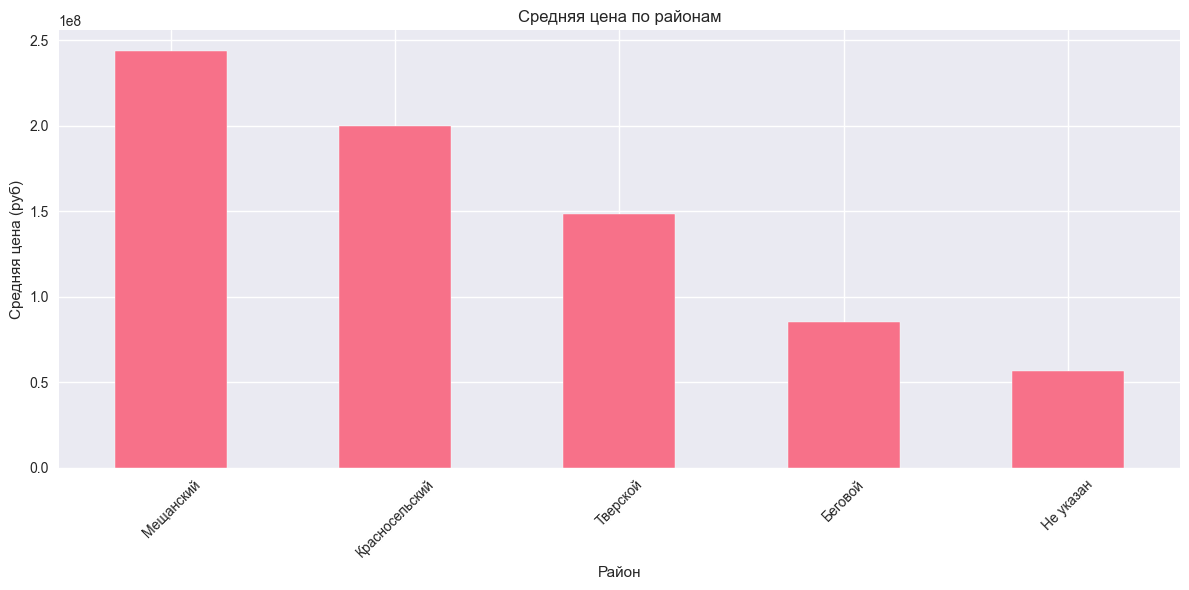

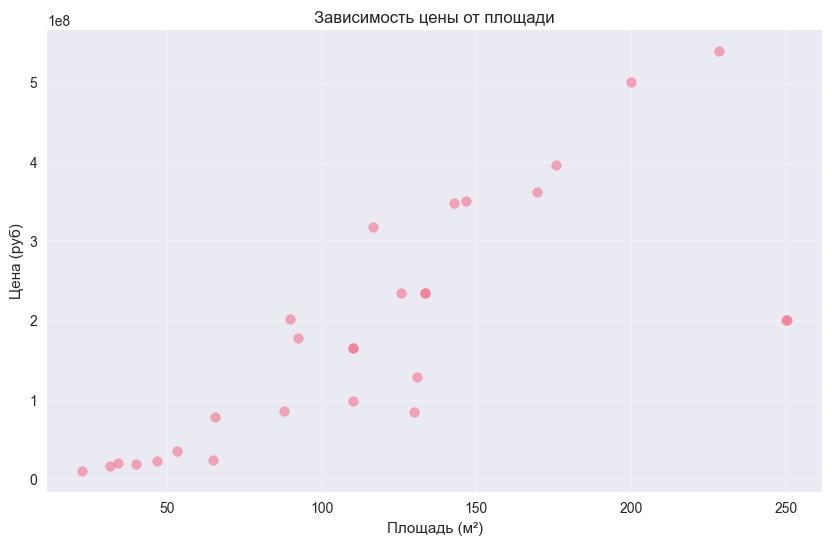

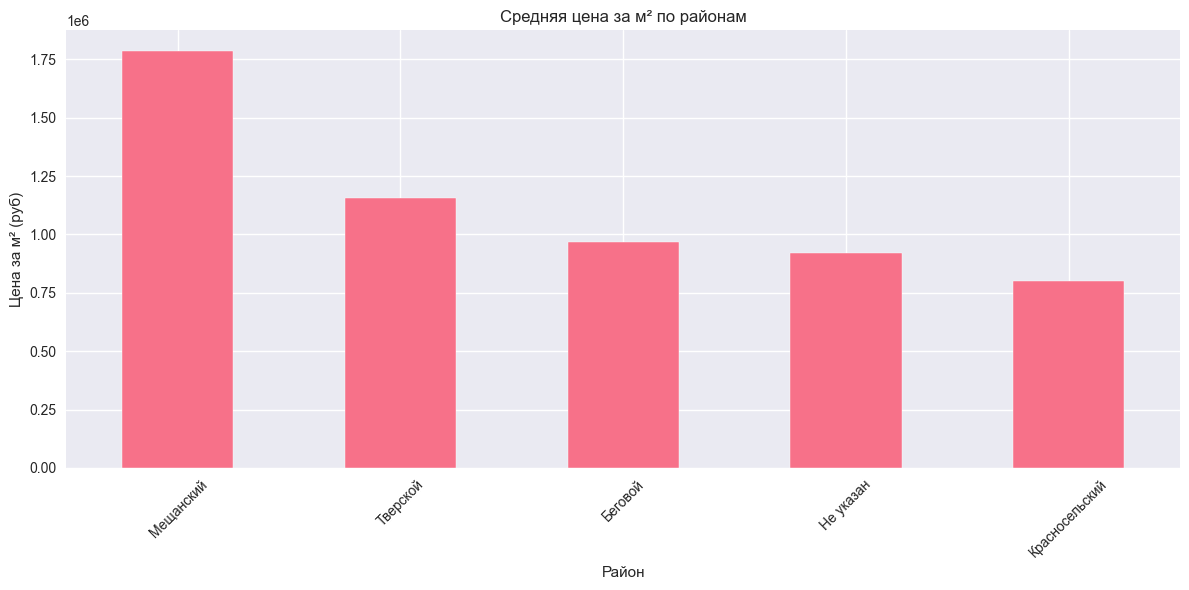

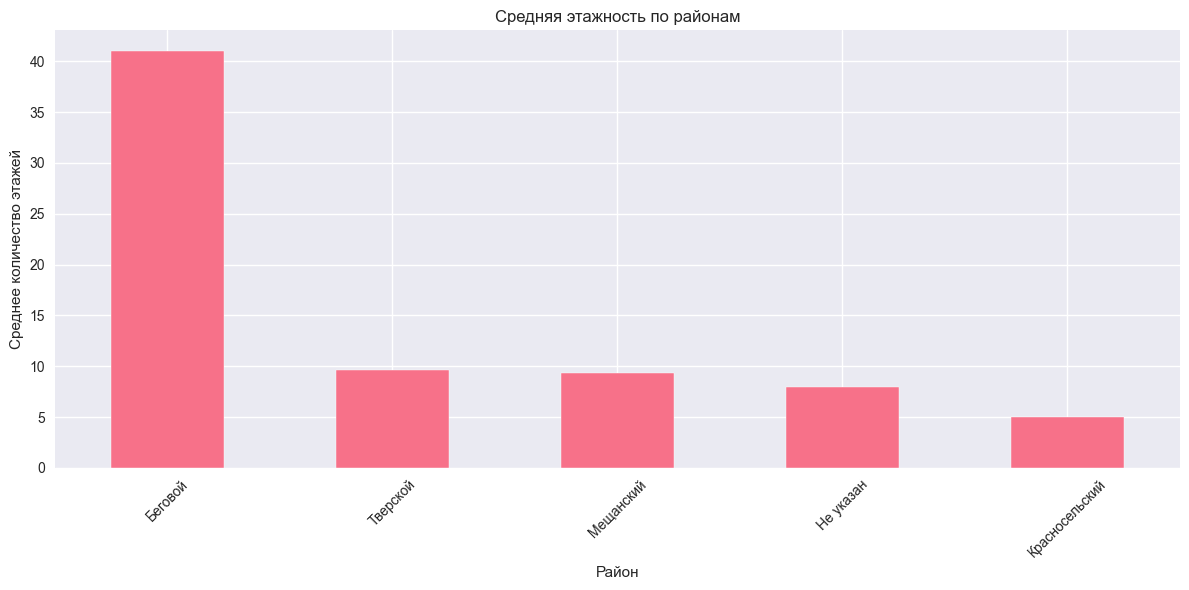

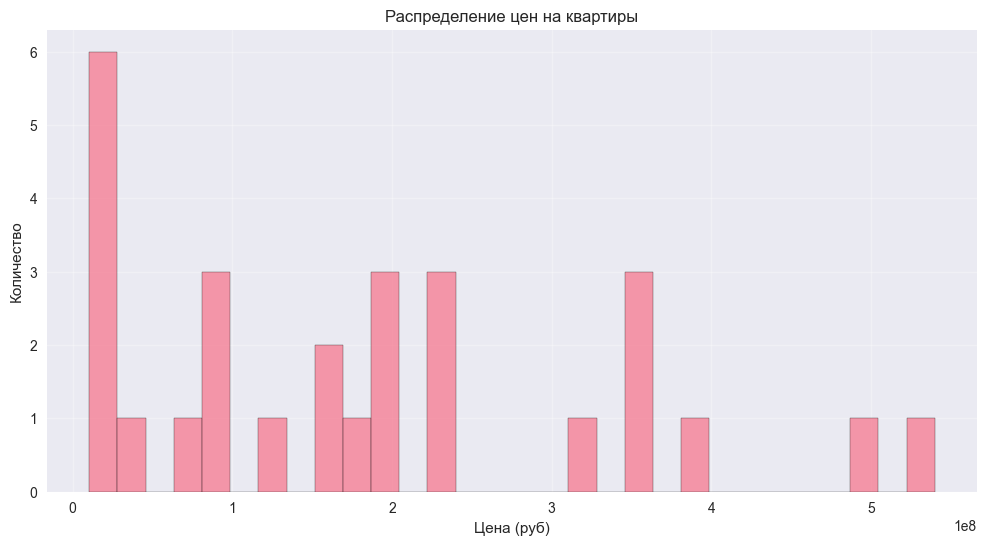

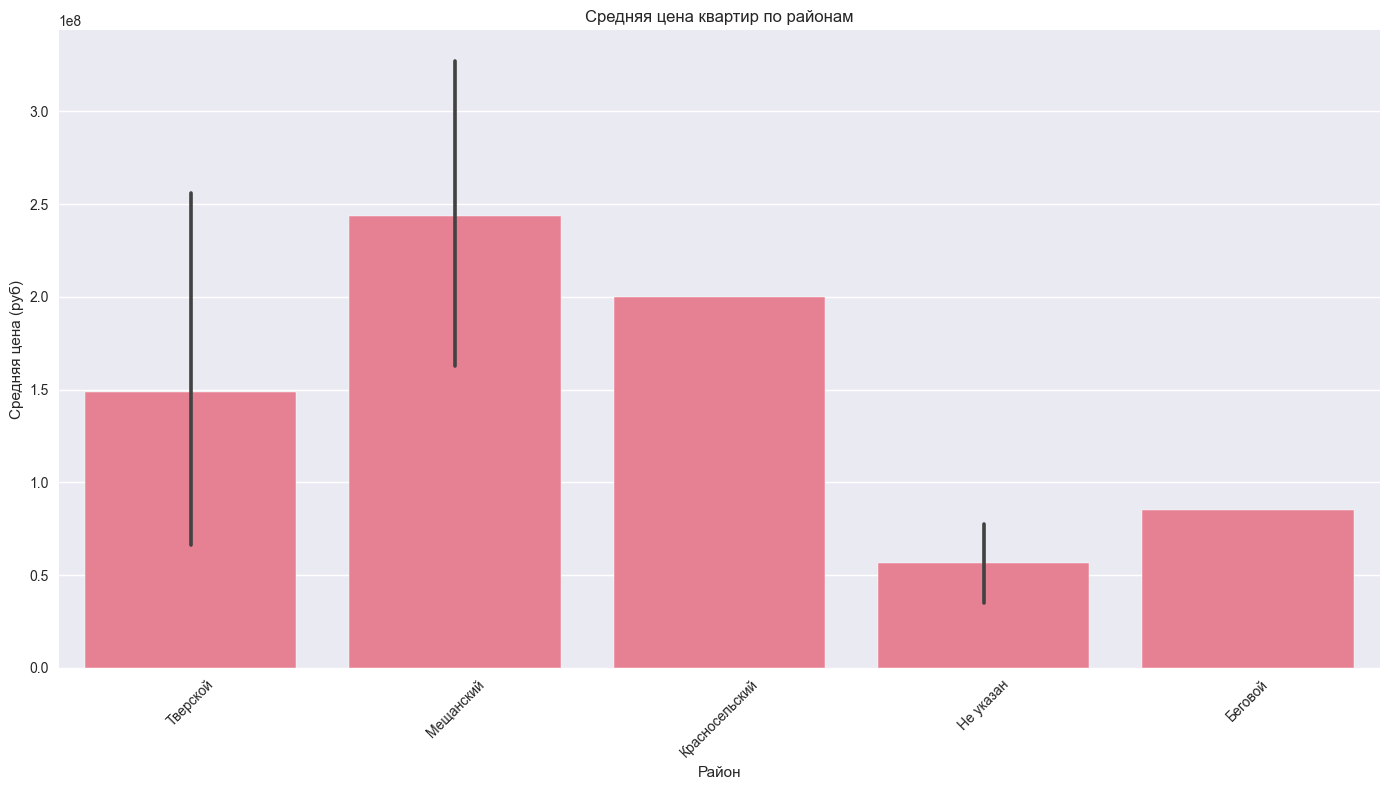

In [59]:
# Исследовательский анализ (EDA)

# 1. Распределение цен по районам
plt.figure(figsize=(12, 6))
district_price = df_clean.groupby('district')['price'].mean().sort_values(ascending=False)
district_price.plot(kind='bar')
plt.title('Средняя цена по районам')
plt.xlabel('Район')
plt.ylabel('Средняя цена (руб)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Зависимость цены от площади
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['total_area'], df_clean['price'], alpha=0.6)
plt.title('Зависимость цены от площади')
plt.xlabel('Площадь (м²)')
plt.ylabel('Цена (руб)')
plt.grid(True, alpha=0.3)
plt.show()

# 3. Средняя цена за квадратный метр по районам
df_clean['price_per_m2'] = df_clean['price'] / df_clean['total_area']
district_price_m2 = df_clean.groupby('district')['price_per_m2'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
district_price_m2.plot(kind='bar')
plt.title('Средняя цена за м² по районам')
plt.xlabel('Район')
plt.ylabel('Цена за м² (руб)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 4. Средняя этажность по районам
district_floors = df_clean.groupby('district')['floors_total'].mean().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
district_floors.plot(kind='bar')
plt.title('Средняя этажность по районам')
plt.xlabel('Район')
plt.ylabel('Среднее количество этажей')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Дополнительные визуализации

# Гистограмма распределения цен
plt.figure(figsize=(12, 6))
plt.hist(df_clean['price'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Распределение цен на квартиры')
plt.xlabel('Цена (руб)')
plt.ylabel('Количество')
plt.grid(True, alpha=0.3)
plt.show()

# Столбчатая диаграмма средней цены по районам (альтернативный вид)
plt.figure(figsize=(14, 8))
sns.barplot(data=df_clean, x='district', y='price', estimator=np.mean)
plt.title('Средняя цена квартир по районам')
plt.xlabel('Район')
plt.ylabel('Средняя цена (руб)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [60]:
# Создание новых признаков
df_features = df_clean.copy()

# 1. Цена за квадратный метр (уже создали ранее)
df_features['price_per_m2'] = df_features['price'] / df_features['total_area']

# 2. Признак новостройки
df_features['is_new_building'] = (df_features['year_built'] >= 2010).astype(int)

# 3. Возраст здания
current_year = 2024
df_features['age'] = current_year - df_features['year_built']
# Заменяем отрицательные значения на NaN
df_features['age'] = df_features['age'].apply(lambda x: x if x > 0 else None)

# 4. Отношение этажа к общему количеству этажей
df_features['floor_ratio'] = df_features['floor'] / df_features['floors_total']

# 5. Расстояние до центра (условно, на основе района)
center_districts = ['Тверской', 'Арбат', 'Хамовники', 'Якиманка']
df_features['center_distance'] = df_features['district'].apply(
    lambda x: 0 if x in center_districts else 1 if x != 'Не указан' else 2
)


# 6. Категория площади
def area_category(area):
    if area < 30:
        return 'small'
    elif area < 60:
        return 'medium'
    elif area < 100:
        return 'large'
    else:
        return 'very_large'


df_features['area_category'] = df_features['total_area'].apply(area_category)


# 7. Этаж категория
def floor_category(floor, total_floors):
    if floor == 1:
        return 'first'
    elif floor == total_floors:
        return 'last'
    else:
        return 'middle'


df_features['floor_category'] = df_features.apply(
    lambda x: floor_category(x['floor'], x['floors_total']), axis=1
)

print("=== НОВЫЕ ПРИЗНАКИ ===")
print(df_features[['price_per_m2', 'is_new_building', 'age', 'floor_ratio',
                   'center_distance', 'area_category', 'floor_category']].head())

=== НОВЫЕ ПРИЗНАКИ ===
   price_per_m2  is_new_building   age  floor_ratio  center_distance  \
0  1.761619e+06                0  16.0     0.300000                0   
1  4.700000e+05                0   NaN     0.555556                0   
2  2.131000e+06                0   NaN     0.846154                1   
3  1.871019e+06                0  16.0     0.300000                0   
4  4.744681e+05                0  50.0     0.666667                1   

  area_category floor_category  
0    very_large         middle  
1        medium         middle  
2    very_large         middle  
3    very_large         middle  
4        medium         middle  


=== АГРЕГИРОВАННЫЕ ПОКАЗАТЕЛИ ===
Средние показатели по районам:
                Средняя цена  Медианная цена  Количество  Средняя цена м²  \
district                                                                    
Беговой         8.528326e+07      85283264.0           1        969128.00   
Красносельский  2.000000e+08     200000000.0           2        799600.40   
Мещанский       2.435820e+08     202050000.0          13       1784647.49   
Не указан       5.640000e+07      56400000.0           2        922223.34   
Тверской        1.484742e+08     106750000.0          10       1157694.28   

                Средняя площадь  Средний возраст  
district                                          
Беговой                   88.00              NaN  
Красносельский           250.12           111.00  
Мещанский                123.38            37.40  
Не указан                 59.40            86.00  
Тверской                  98.19            40.14  

Статистика по категориям площади:
   

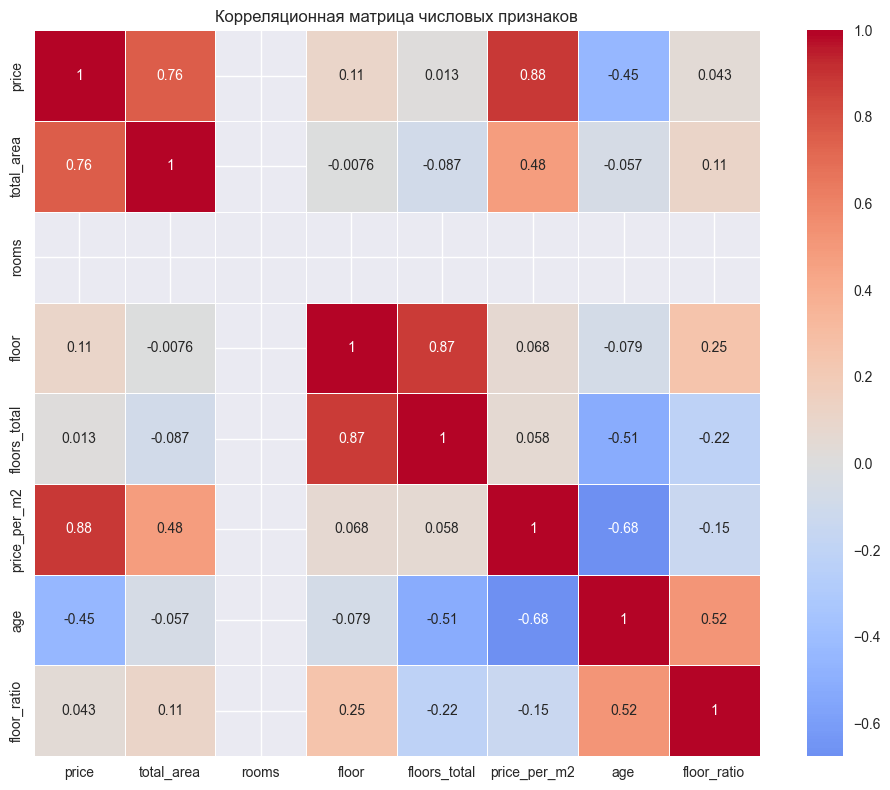


Сравнение новостроек и вторичного жилья:
                    price  price_per_m2  total_area
Вторичка     1.800580e+08    1366634.44      115.12
Новостройка  2.320000e+08    1597727.27      132.50


In [62]:
# Агрегированные показатели
print("=== АГРЕГИРОВАННЫЕ ПОКАЗАТЕЛИ ===")

# Средняя цена по районам
avg_price_by_district = df_features.groupby('district').agg({
    'price': ['mean', 'median', 'count'],
    'price_per_m2': 'mean',
    'total_area': 'mean',
    'age': 'mean'
}).round(2)

avg_price_by_district.columns = ['Средняя цена', 'Медианная цена', 'Количество',
                                 'Средняя цена м²', 'Средняя площадь', 'Средний возраст']
print("Средние показатели по районам:")
print(avg_price_by_district)

# Статистика по типам площади
print("\nСтатистика по категориям площади:")
area_stats = df_features.groupby('area_category').agg({
    'price': 'mean',
    'price_per_m2': 'mean',
    'total_area': 'mean'
}).round(2)
print(area_stats)

# Корреляционный анализ
print("\nКорреляционная матрица:")
numeric_cols = ['price', 'total_area', 'rooms', 'floor', 'floors_total',
                'price_per_m2', 'age', 'floor_ratio']
correlation_matrix = df_features[numeric_cols].corr()
print(correlation_matrix.round(3))

# Финальные визуализации и выводы

# Топ-5 самых дорогих районов
top_expensive = avg_price_by_district.nlargest(5, 'Средняя цена м²')
print("=== ТОП-5 САМЫХ ДОРОГИХ РАЙОНОВ ===")
print(top_expensive[['Средняя цена м²', 'Средняя цена']])

# Визуализация корреляций
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Корреляционная матрица числовых признаков')
plt.tight_layout()
plt.show()

# Сравнение новостроек и вторичного жилья
if 'is_new_building' in df_features.columns:
    new_vs_old = df_features.groupby('is_new_building').agg({
        'price': 'mean',
        'price_per_m2': 'mean',
        'total_area': 'mean'
    }).round(2)
    new_vs_old.index = ['Вторичка', 'Новостройка']
    print("\nСравнение новостроек и вторичного жилья:")
    print(new_vs_old)